In [1]:
%matplotlib inline

import os
# assumes jupyter server launched from root dir of repo
filepath = os.path.abspath(os.path.join(os.getcwd(), '..'))
%cd $filepath

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.append(os.path.abspath(filepath))

from common import *
from cces_util import *
from notebooks.eval_util import *

/Users/cyz/survey/active_survey


Using TensorFlow backend.


In [2]:
# Suppress verbose warnings about missing fonts
import warnings
warnings.simplefilter('ignore')

In [3]:
dataset = 'cces16_t1000_s1000'
sim_objects_filename = '{}/data/{}-sim-objects.pkl'.format(filepath, dataset)
response_filename = filepath + '/data/cces/cces16_ord.csv'
question_filename = filepath + "/data/cces/cces16_questions_short.csv"

In [4]:
sim_objects = deserialize(sim_objects_filename)

In [5]:
responses = pd.read_csv(response_filename, index_col=0)
questions = responses.columns.tolist()

In [6]:
question_df = pd.read_csv(question_filename, index_col=0)
question_to_label = {row['question']: row['text'] for index, row in question_df.iterrows()}
question_to_label

{'CC16_302': 'National Economy',
 'CC16_303': 'Past year household income',
 'CC16_304': 'Next year household income',
 'CC16_307': 'Police make R feel safe',
 'CC16_320a': 'Approve of Job - Obama',
 'CC16_320b': 'Approve of Job - Congress',
 'CC16_320c': 'Approve of Job - Supreme Court',
 'CC16_330a': 'Gun Control - Background checks',
 'CC16_330b': 'Gun Control - Gun owner privacy',
 'CC16_330d': 'Gun Control - Ban assault rifles',
 'CC16_330e': 'Gun Control - Easier concealed-carry',
 'CC16_331_1': 'Immigration - Legalize law-abiding',
 'CC16_331_2': 'Immigration - Increase border patrols',
 'CC16_331_3': 'Immigration - Legalize Dreamers',
 'CC16_331_7': 'Immigration - Deport illegal immigrants',
 'CC16_331_9': 'Immigration - None of these',
 'CC16_332a': 'Abortion - Always allow',
 'CC16_332b': 'Abortion - Only in case of rape, incest',
 'CC16_332c': 'Abortion - Ban after 20th week',
 'CC16_332d': 'Abortion - Decline insurance coverage',
 'CC16_332e': 'Abortion - No federal funds',

In [7]:
alpha = 1

In [8]:
# plt.style.use('ggplot')
# plt.rcParams.update({'font.size': 12})
# plot_question_order(sim_objects, questions,
#                     rank=2, optimality_type='A', v_method='row-norm', alpha=alpha,
#                     max_labels=20, max_plots=1, plot_position_only=True)

In [9]:
# maybe these are axis-aligned because of mean-field variational inference!

In [26]:
# redefined
def extract_from_cache(cache, key):
    return {idx: [qinfo[key] for qinfo in idx_result] for idx, idx_result in cache.items()}

# redefined
def plot_question_ranks(sim_objects, questions, rank, optimality_type, v_method, alpha, subgroup='all', 
    show_question_labels=False, question_to_label=None, show_max_questions=None, plot_type='box',
    max_label_length=80, sort_by_rank=True):
    
    # BEGIN redefined section
    n_questions = len(questions)
    sim_keys = get_active_sim_keys(sim_objects, rank, optimality_type, v_method, alpha)
    sim_key = sim_keys[0]
    id_to_question_order = extract_from_cache(sim_objects[sim_key]['cache'], 'question')
    all_question_ranks = np.vstack([compute_question_ranks(question_order, n_questions) 
        for question_order in id_to_question_order.values()])
    # END redefined section
    
    # replace NA ranks with last rank (number of questions)
    all_question_ranks[np.isnan(all_question_ranks)] = n_questions
    avg_question_ranks = np.median(all_question_ranks, axis=0)

    avg_rank_df = pd.DataFrame({
        'question': questions, 
        'avg_rank': avg_question_ranks, 
        'position': np.argsort(np.argsort(avg_question_ranks))
    }).set_index('question')

    if sort_by_rank:
        sorted_rank_df = avg_rank_df.sort_values(by='position', ascending=False)
    else:
        sorted_rank_df = avg_rank_df.sort_index(ascending=False)
    sorted_questions = sorted_rank_df.index.tolist()

    if show_max_questions is not None:
        n_questions = show_max_questions
        sorted_questions = sorted_questions[-n_questions:]

    y_range = range(n_questions)
    
    sns.set_style("whitegrid")
    plt.rcParams["figure.figsize"] = (5, n_questions / 2.5)
    plt.figure()

    all_question_ranks_df = pd.DataFrame(all_question_ranks, columns=questions)
    sns.boxplot(data=all_question_ranks_df[sorted_questions], orient='h', color="lightgray")
    
    ytick_labels = ["{} ({:d})".format(question, avg_rank_df['position'][question]+1) 
        for i, question in zip(y_range[::-1], sorted_questions)]
    plt.yticks(y_range, ytick_labels, size=16)
    plt.xticks(size=16)
    if show_question_labels:
        assert question_to_label is not None
        for i in y_range:
            question = sorted_questions[i]
            label = label_for_question(question, question_to_label)
            if not sort_by_rank and avg_rank_df['position'][question] < 10:
                weight = 'bold'
            else:
                weight = 'normal'
            plt.text(n_questions+1, i-0.25, label[:max_label_length], weight = weight, size=16)
    plt.xlim(0, n_questions+1)
    plt.ylim(-1, n_questions)
    subgroup_str = 'all users' if subgroup == 'all' else subgroup
    plt.title("Active question order for {:d} users in one simulation".format(len(id_to_question_order)), y=1.01, size=20)

    # print('\n'.join(sorted_questions[::-1]))

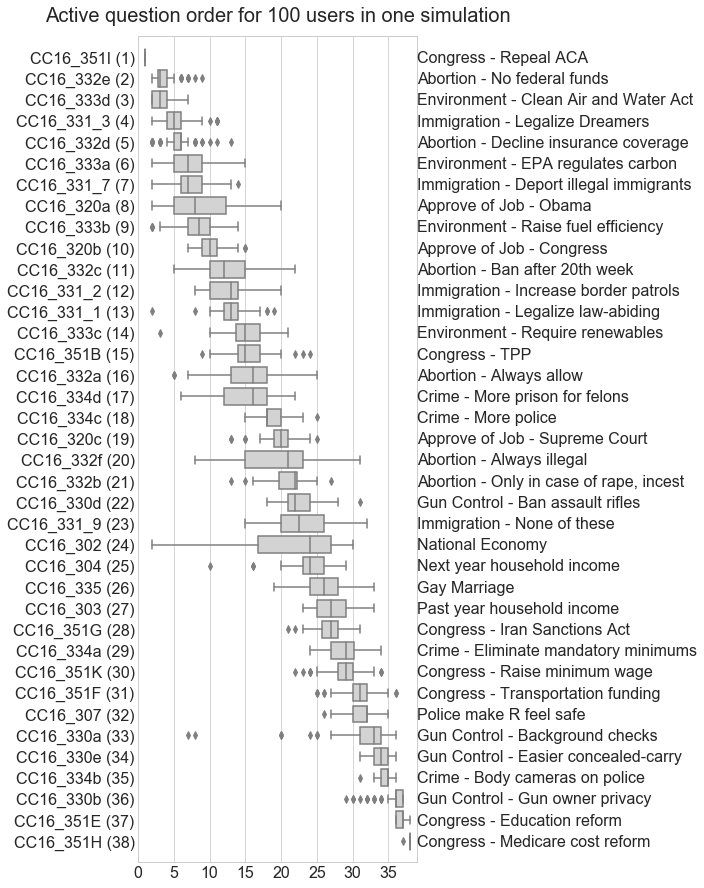

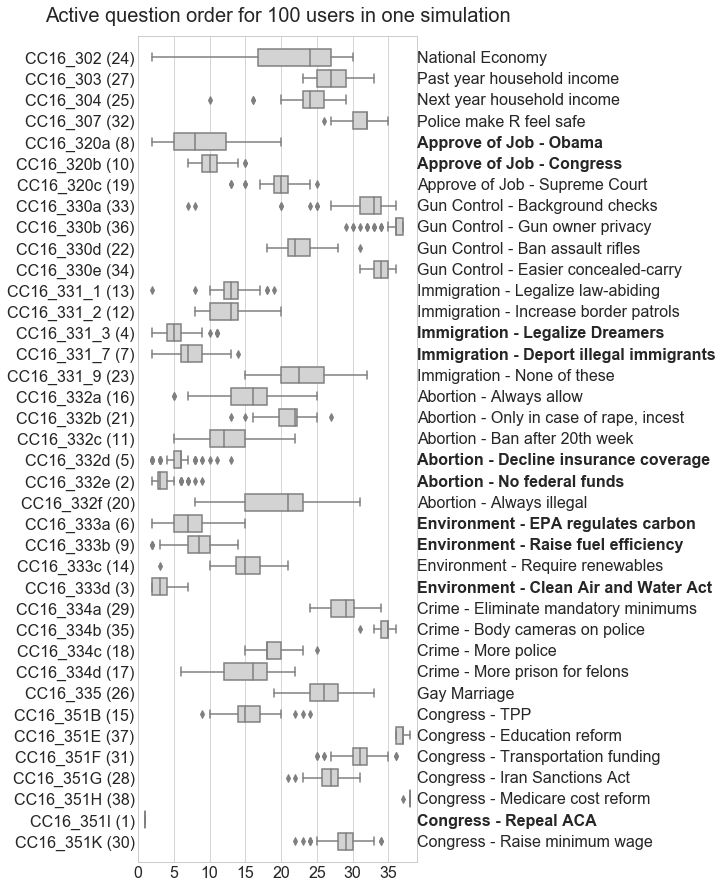

In [27]:
plot_question_ranks(sim_objects, questions,
                    rank=4, optimality_type='A', v_method='row-norm', alpha=alpha,
                    show_question_labels=True, question_to_label=question_to_label)

plot_question_ranks(sim_objects, questions,
                    rank=4, optimality_type='A', v_method='row-norm', alpha=alpha,
                    show_question_labels=True, question_to_label=question_to_label, 
                    sort_by_rank=False)

In [24]:
def plot_question_paths(sim_objects, questions, rank, optimality_type, v_method, alpha):
    n_questions = len(questions)
    sim_keys = get_active_sim_keys(sim_objects, rank, optimality_type, v_method, alpha)
    sim_key = sim_keys[0]
    id_to_question_order = extract_from_cache(sim_objects[sim_key]['cache'], 'question')

    all_question_ranks = np.vstack([compute_question_ranks(question_order, n_questions) 
        for question_order in id_to_question_order.values()])
    # replace NA ranks with last rank (number of questions)
    all_question_ranks[np.isnan(all_question_ranks)] = n_questions
    avg_question_ranks = np.median(all_question_ranks, axis=0)
    sorted_question_ranks = pd.Series(avg_question_ranks, index=questions).sort_values(ascending=False)
    sorted_questions = sorted_question_ranks.index.tolist()
    question_to_ypos = {q: ypos for ypos, q in enumerate(sorted_questions)}
    # use this to map questions to y-axis
    
    plt.rcParams["figure.figsize"] = (16, 12)
    plt.figure()
    sns.set_style('white')
    
    for question_order in id_to_question_order.values():
        ys = [question_to_ypos[questions[q]] for q in question_order]
        plt.plot(range(n_questions), ys, color='gray', alpha=0.08)
        plt.scatter(range(n_questions), ys, color='gray', alpha=0.5)

    plt.xlabel("Question position", size=16)
    plt.xticks(size=16)
    plt.yticks([question_to_ypos[questions[q]] for q in range(n_questions)], 
               [question_to_label[q] for q in questions], size=16)
    
    plt.xlim(-0.2, n_questions)
    plt.ylim(-0.5, n_questions)
    plt.box(on=False)

    plt.title("Path through questions for {:d} users in one simulation".format(len(id_to_question_order), rank), y=1.01, size=20)

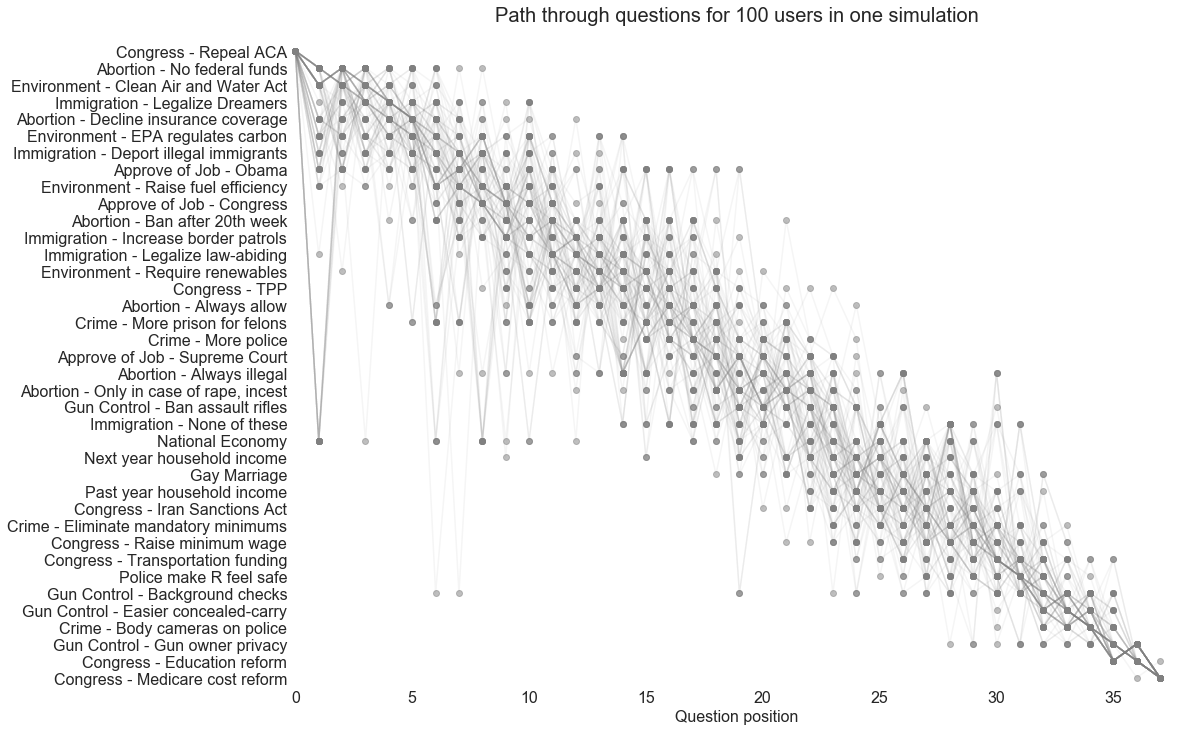

In [25]:
plot_question_paths(sim_objects, questions,
                    rank=4, optimality_type='A', v_method='row-norm', alpha=alpha)